In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Data/Devnagari.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

In [3]:
# prompt: show the extracted_data

import os

extracted_data_path = 'extracted_data'

if os.path.exists(extracted_data_path):
    print(f"Contents of {extracted_data_path}:")
    for item in os.listdir(extracted_data_path):
        print(item)
else:
  print(f"The directory '{extracted_data_path}' does not exist.")

Contents of extracted_data:
DevanagariHandwrittenDigitDataset


In [4]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [5]:
!pip install --upgrade tensorflow

In [6]:
print(tf.keras.__version__)

3.8.0


In [30]:
import numpy as np
# Simple function f(x) = x^2
def f(x):
  return x ** 2
# Manual derivative (f'(x) = 2x)
def gradient(x):
  return 2 * x
# Update rule: x = x - learning_rate * gradient
x = 5.0
learning_rate = 0.1
for _ in range(10): # Manually optimize for 10 steps
  x -= learning_rate * gradient(x)
print(f"x: {x}, f(x): {f(x)}")

x: 0.5368709120000001, f(x): 0.2882303761517119


In [31]:
x = tf.Variable(5.0) # Trainable variable
with tf.GradientTape() as tape:
  y = x ** 2 # y = x^2
grad = tape.gradient(y, x) # Computes dy/dx automatically
print(grad.numpy()) # Output: 10.0

10.0


In [32]:
import numpy as np
import tensorflow as tf
import time
# Create large random matrices
size = (1000, 1000)
A = np.random.rand(*size)
B = np.random.rand(*size)
# NumPy Multiplication
start = time.time()
C_numpy = np.dot(A, B)
print("NumPy Time:", time.time() - start)
# TensorFlow Multiplication (for colab uses GPU Runtime if available)
A_tf = tf.constant(A)
B_tf = tf.constant(B)
start = time.time()
C_tf = tf.matmul(A_tf, B_tf)
print("TensorFlow Time:", time.time() - start)

NumPy Time: 0.06165671348571777
TensorFlow Time: 0.014879226684570312


# 1. Data Preparation

Training set: (17000, 28, 28, 1), Labels: (17000, 10)
Testing set: (3000, 28, 28, 1), Labels: (3000, 10)


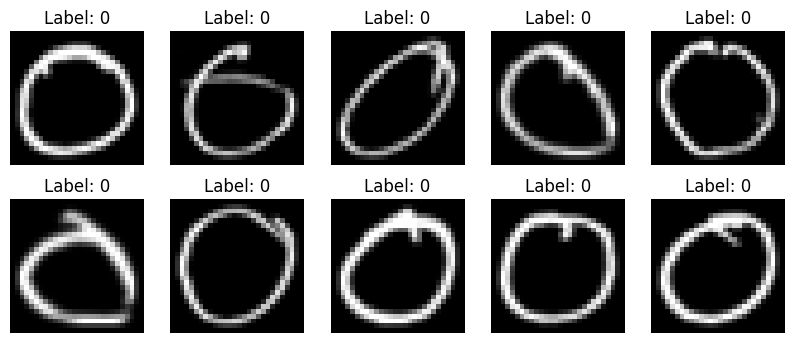

In [18]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow

# Define dataset paths
train_dir = "extracted_data/DevanagariHandwrittenDigitDataset/Train"
test_dir = "extracted_data/DevanagariHandwrittenDigitDataset/Test"

# Define image size
img_height, img_width = 28, 28

# Function to load images and labels using PIL
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
    class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels

    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            # Load image using PIL
            img = Image.open(img_path).convert("L") # Convert to grayscale
            img = img.resize((img_width, img_height)) # Resize to (28,28)
            img = np.array(img) / 255.0 # Normalize pixel values to [0,1]
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and testing datasets
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)

# Reshape images for Keras input
x_train = x_train.reshape(-1, img_height, img_width, 1) # Shape (num_samples, 28, 28, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Print dataset shape
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")

# Visualize some images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")
plt.show()

# 2. Building FCN Model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input

num_classes = 10
input_shape = (28, 28, 1)

model = Sequential([
    Input(shape=input_shape),
    Flatten(),  # Convert 2D image to 1D vector
    Dense(64, activation="sigmoid"),
    Dense(128, activation="sigmoid"),
    Dense(256, activation="sigmoid"),
    Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

# 3. Compiling the Model

In [23]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # Use "sparse_categorical_crossentropy" if labels are not one-hot encoded
    metrics=["accuracy"]
)

# 4. Training the Model

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 128
epochs = 20

callbacks = [
    ModelCheckpoint(filepath="model_epoch_{epoch}.h5", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
]

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3028 - loss: 1.9838

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3046 - loss: 1.9806 - val_accuracy: 0.0000e+00 - val_loss: 7.3694
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8129 - loss: 0.6398 - val_accuracy: 0.0000e+00 - val_loss: 8.7373
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9017 - loss: 0.3184 - val_accuracy: 0.0000e+00 - val_loss: 9.4817
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9378 - loss: 0.2192 - val_accuracy: 0.0000e+00 - val_loss: 9.8679
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 0.1607 - val_accuracy: 0.0000e+00 - val_loss: 10.1616


# 5. Evaluating the Model

In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

94/94 - 1s - 9ms/step - accuracy: 0.6237 - loss: 2.1447
Test accuracy: 0.6237


# 6. Saving and Loading the Model

In [26]:
# Save the model
model.save("devnagari_fcn_model.h5")

# Later or in a new session, load the model
loaded_model = tf.keras.models.load_model("devnagari_fcn_model.h5")

# Evaluate the loaded model to confirm similar performance
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(x_test, y_test, verbose=2)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")

94/94 - 1s - 13ms/step - accuracy: 0.6237 - loss: 2.1447
Loaded model test accuracy: 0.6237


# 7. Making Predictions

In [27]:
# Predict on test data
predictions = loaded_model.predict(x_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Display the first prediction vs. true label
print(f"Predicted label for first image: {predicted_labels[0]}")
print(f"True label for first image: {true_labels[0]}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted label for first image: 0
True label for first image: 0


# 8. Visualization of Training Process

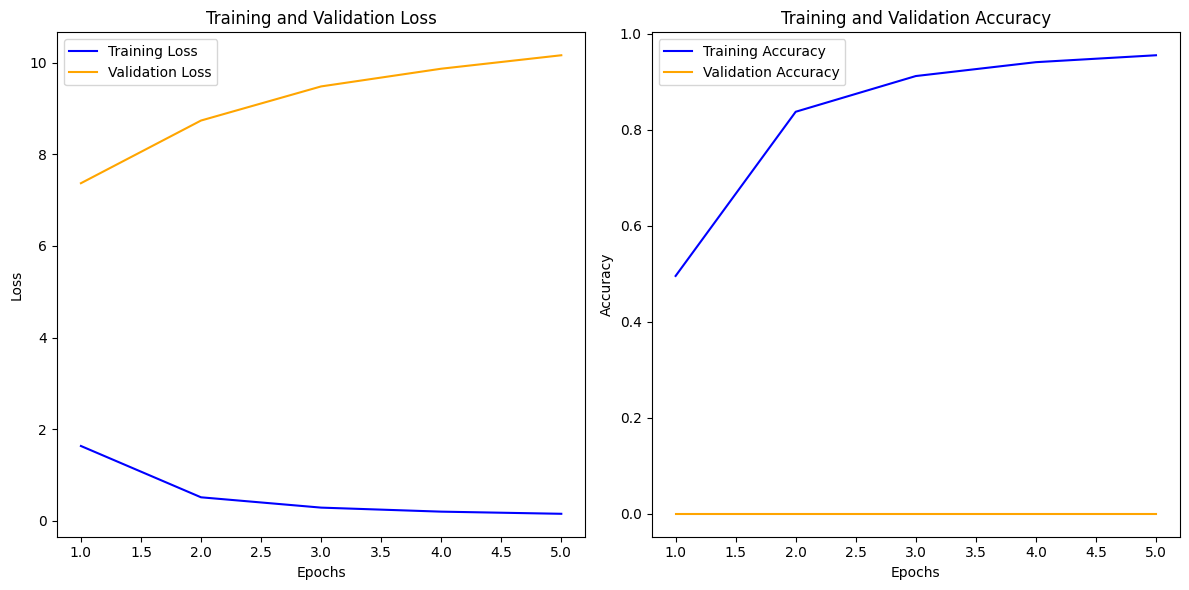

In [29]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Extracting training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting training and validation accuracy (if metrics were specified)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()